In [8]:
import csv
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np

from tqdm.auto import tqdm
from pathlib import Path
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"

BATCH_SIZE = 16
IMAGE_SHAPE = (128, 128)

PROCESSED_DATASET_PATH_ANIMAL10_TRAIN = Path("/kaggle/input/animal-10/splitData/Train")
PROCESSED_DATASET_PATH_ANIMAL10_TEST = Path("/kaggle/input/animal-10/splitData/Test")
PROCESSED_DATASET_PATH_ANIMAL10_VAL = Path("/kaggle/input/animal-10/splitData/Validation")

# PRETRAINED_MODEL = "/kaggle/input/modele2/e2.pth"

print(device)

cuda:0


In [9]:
train_transform = transforms.Compose([
    transforms.Resize(IMAGE_SHAPE),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
    transforms.Resize(IMAGE_SHAPE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

train_set = datasets.ImageFolder(PROCESSED_DATASET_PATH_ANIMAL10_TRAIN, transform=train_transform)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)

val_set = datasets.ImageFolder(PROCESSED_DATASET_PATH_ANIMAL10_VAL, transform=test_transform)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True)

test_set = datasets.ImageFolder(PROCESSED_DATASET_PATH_ANIMAL10_TEST, transform=test_transform)
test_loader = DataLoader(test_set, shuffle=True)

print(len(train_set), len(val_set), len(test_set), train_set.classes)
print(val_set)


14676 2094 4199 ['cat', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']
Dataset ImageFolder
    Number of datapoints: 2094
    Root location: /kaggle/input/animal-10/splitData/Validation
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


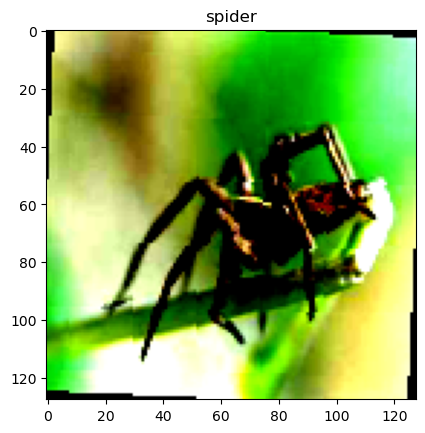

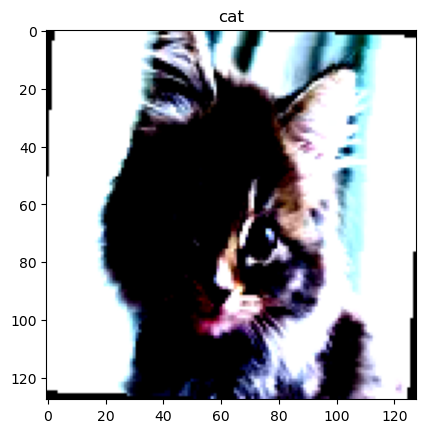

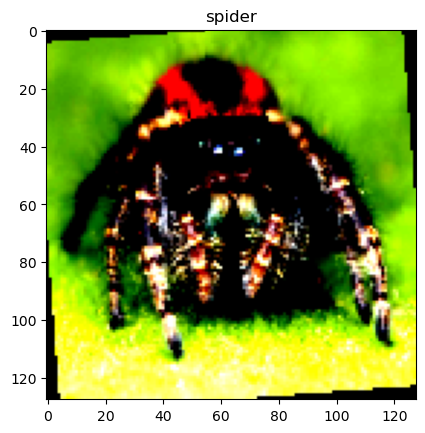

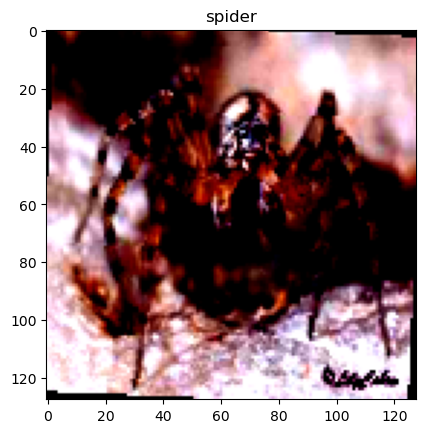

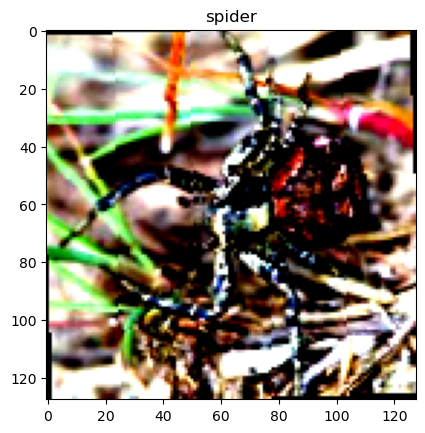

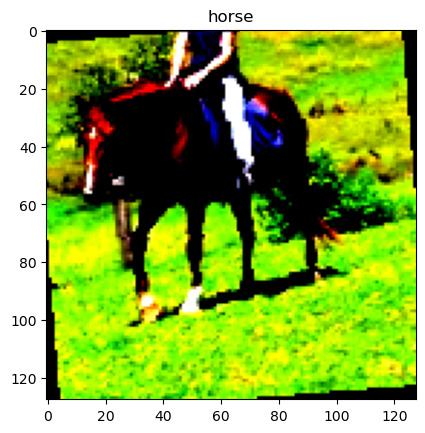

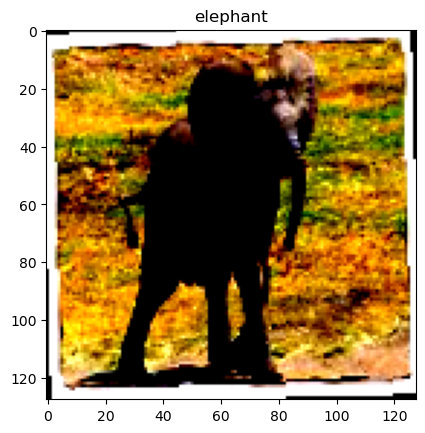

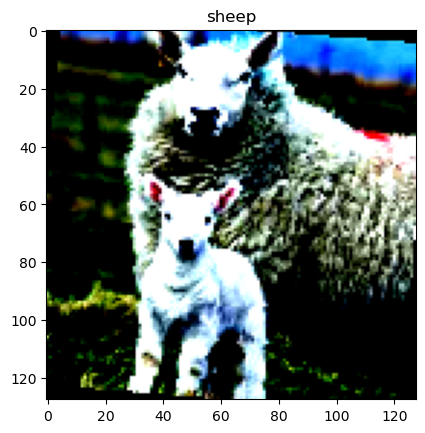

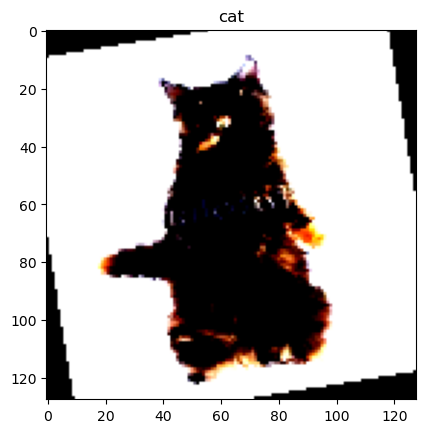

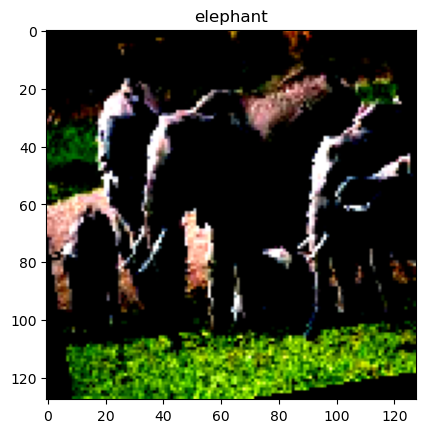

8


In [3]:
train_loader_vis = torch.utils.data.DataLoader(train_set, 15, shuffle=True)

images, labels = next(iter(train_loader_vis))
images, labels = images.numpy() , labels.numpy()

for i in range(10):
    plt.imshow(np.transpose(images[i] , (1,2,0)))
    plt.title(train_set.classes[labels[i]])
    plt.show()
print(len(train_set.classes))

In [4]:
print("Unique classes number : ",len(train_set.classes))
print("Classes : ", train_set.classes)

Unique classes number :  8

Classes :  ['cat', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']


# class distribution

In [12]:
import os

train = {}
test = {}
val = {}


for class_ in os.listdir(PROCESSED_DATASET_PATH_ANIMAL10_TRAIN):
    train[class_] = len([x for x in os.listdir(f"{PROCESSED_DATASET_PATH_MNETV1_TRAIN}/{class_}") ])


for class_ in os.listdir(PROCESSED_DATASET_PATH_ANIMAL10_TEST):
    test[class_] = len([x for x in os.listdir(f"{PROCESSED_DATASET_PATH_MNETV1_TEST}/{class_}")])

for class_ in os.listdir(PROCESSED_DATASET_PATH_ANIMAL10_VAL):
    val[class_] = len([x for x in os.listdir(f"{PROCESSED_DATASET_PATH_MNETV1_VAL}/{class_}")])

print(train, test, val)

{'spider': 3374, 'horse': 1836, 'dog': 3404, 'elephant': 1012, 'sheep': 1274, 'cow': 1306, 'squirrel': 1303, 'cat': 1167} {'spider': 965, 'horse': 525, 'dog': 973, 'elephant': 290, 'sheep': 364, 'cow': 374, 'squirrel': 373, 'cat': 335} {'spider': 482, 'horse': 262, 'dog': 486, 'elephant': 144, 'sheep': 182, 'cow': 186, 'squirrel': 186, 'cat': 166}


In [13]:
import numpy as np
data = {"y": []}
classes = []
for key in train.keys():
    data["y"].append(train[key] + val[key] + test[key])
    classes.append(key)

for k, v in data.items():
    data[k] = np.array(v)
print(data, classes)

{'y': array([4821, 2623, 4863, 1446, 1820, 1866, 1862, 1668])} ['spider', 'horse', 'dog', 'elephant', 'sheep', 'cow', 'squirrel', 'cat']


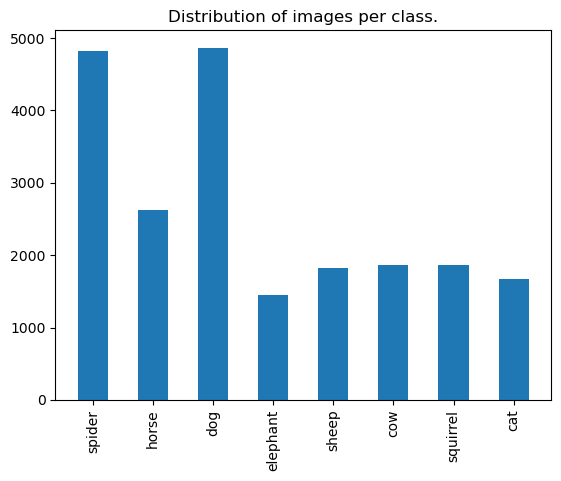

In [14]:
import numpy as np
import matplotlib.pyplot as plt

width = 0.5

fig, ax = plt.subplots()
bottom = np.zeros(8)

for k, v in data.items():
    p = ax.bar(classes, v, width, label=k, bottom=bottom)
    bottom += v

ax.set_title("Distribution of images per class.")

plt.xticks(rotation=90)
plt.show()

In [5]:
from torchvision import models
import torch.nn.functional as F
from collections import OrderedDict

model = models.mobilenet_v2(num_classes=len(train_set.classes),pretrained=False)
model = model.to(device)
model.eval()

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.

  warnings.warn(msg)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [8]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [9]:
import os
os.makedirs("/kaggle/working/mods")

In [17]:
import pandas as pd
open("/kaggle/working/logs.csv", "a", newline="")
log_file = open("/kaggle/working/logs.csv", "a", newline="")
csv_writer = csv.writer(log_file)
csv_writer.writerow(["epoch", "train_loss", "train_acc", "val_loss", "val_acc"])

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer):
    try:
        if mode == 'train':
            model.train()
        elif mode == 'val':
            model.eval()

        loss = correct = 0
        for feature, target in tqdm(dataloader, desc=mode.title()):
            feature, target = feature.to(device), target.to(device)
            output = model(feature)
            loss = criterion(output, target)

            if mode == 'train':
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

            loss += loss.item() * feature.shape[0]
            correct += (output.argmax(1) == target).sum().item()
        loss = loss/len(dataset)
        accuracy = correct/len(dataset)
        return loss, accuracy
    except:
        pass

result_df = pd.DataFrame(columns=['epoch', 'train_loss','train_acc','val_loss','val_acc'])
result_list = []
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    try:
        train_cost, train_score = loop_fn('train', train_set, train_loader, model, criterion, optimizer)
        with torch.no_grad():
            test_cost, test_score = loop_fn('val', val_set, val_loader, model, criterion, optimizer)
        print(epoch, float(train_cost), train_score, float(test_cost), test_score)
        row_dict = {'epoch':epoch,'train_loss':float(train_cost),'train_acc':train_score,'val_loss':float(test_cost),'val_acc':test_score} 
        result_list.append(row_dict)
        csv_writer.writerow([epoch, float(train_cost), train_score, float(test_cost), test_score])
        torch.save(model.state_dict(), f"/kaggle/working/mods/_e{epoch}.pth")
    except:
        pass
result_df = pd.DataFrame.from_dict(result_list)

Train:   0%|          | 0/918 [00:00<?, ?it/s]

Val:   0%|          | 0/131 [00:00<?, ?it/s]

1 7.154847116908059e-05 0.7067320795857182 0.0029949245508760214 0.7187201528175741


Train:   0%|          | 0/918 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x75602f9f5b90>

Traceback (most recent call last):

  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__

    self._shutdown_workers()

  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers

    if w.is_alive():

  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive

    assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError: can only test a child process


Val:   0%|          | 0/131 [00:00<?, ?it/s]

2 0.00017595020472072065 0.7151812482965386 0.010176614858210087 0.7177650429799427


Train:   0%|          | 0/918 [00:00<?, ?it/s]

Val:   0%|          | 0/131 [00:00<?, ?it/s]

3 0.000442586955614388 0.7089125102207686 0.007187051232904196 0.7206303724928367


Train:   0%|          | 0/918 [00:00<?, ?it/s]

Val:   0%|          | 0/131 [00:00<?, ?it/s]

4 0.000566263624932617 0.7053693104388117 0.007506216876208782 0.7177650429799427


Train:   0%|          | 0/918 [00:00<?, ?it/s]

Val:   0%|          | 0/131 [00:00<?, ?it/s]

5 0.0002511735074222088 0.7068002180430635 0.004034456796944141 0.7168099331423113


Train:   0%|          | 0/918 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x75602f9f5b90>

Traceback (most recent call last):

  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__

    self._shutdown_workers()

  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers

    if w.is_alive():

  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive

    assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError: can only test a child process


Val:   0%|          | 0/131 [00:00<?, ?it/s]

6 0.00012165773659944534 0.7034614336331425 0.006319123320281506 0.7177650429799427


Train:   0%|          | 0/918 [00:00<?, ?it/s]

Val:   0%|          | 0/131 [00:00<?, ?it/s]

7 0.0005620280280709267 0.7046879258653584 0.001959951827302575 0.711556829035339


Train:   0%|          | 0/918 [00:00<?, ?it/s]

Val:   0%|          | 0/131 [00:00<?, ?it/s]

8 0.0003664874820969999 0.7100027255382938 0.007555077318102121 0.7163323782234957


Train:   0%|          | 0/918 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x75602f9f5b90>

Traceback (most recent call last):

  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__

    self._shutdown_workers()

  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers

    if w.is_alive():

  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive

    assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError: can only test a child process


Val:   0%|          | 0/131 [00:00<?, ?it/s]

9 0.000317928206641227 0.7060506950122649 0.005801201798021793 0.7172874880611271


Train:   0%|          | 0/918 [00:00<?, ?it/s]

Val:   0%|          | 0/131 [00:00<?, ?it/s]

10 0.00017081429541576654 0.7061869719269556 0.005882346071302891 0.7187201528175741


In [18]:
BATCH_SIZE = 10


PRETRAINED_MODEL = "/kaggle/working/mods/_e8.pth"

In [19]:
result_df

,epoch,train_loss,train_acc,val_loss,val_acc
0,1,0.000072,0.706732,0.002995,0.718720
1,2,0.000176,0.715181,0.010177,0.717765
2,3,0.000443,0.708913,0.007187,0.720630
3,4,0.000566,0.705369,0.007506,0.717765
4,5,0.000251,0.706800,0.004034,0.716810
5,6,0.000122,0.703461,0.006319,0.717765
6,7,0.000562,0.704688,0.001960,0.711557
7,8,0.000366,0.710003,0.007555,0.716332
8,9,0.000318,0.706051,0.005801,0.717287
9,10,0.000171,0.706187,0.005882,0.718720


In [20]:
testset = torchvision.datasets.ImageFolder( PROCESSED_DATASET_PATH_ANIMAL10_TEST,transform = transforms)
testloader = torch.utils.data.DataLoader(testset  , batch_size=BATCH_SIZE)

In [21]:
from torchvision import models
import torch.nn.functional as F
from collections import OrderedDict
my_gpu = torch.cuda.is_available()
device = torch.device('cuda' if my_gpu else 'cpu')
device
model = models.mobilenet_v2(num_classes=len(testset.classes),pretrained=False)
model = model.to(device)
model.load_state_dict(torch.load(PRETRAINED_MODEL))
model.eval()

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.

  warnings.warn(msg)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

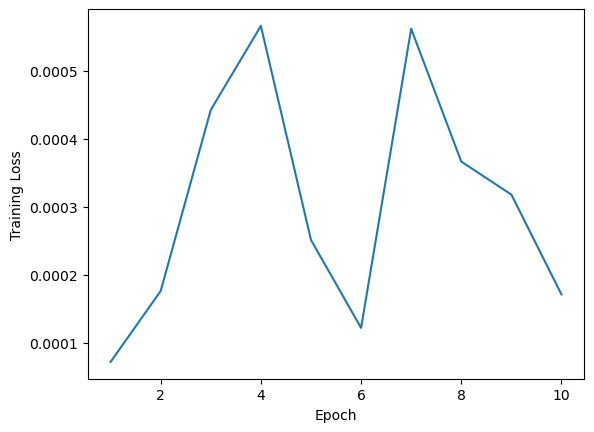

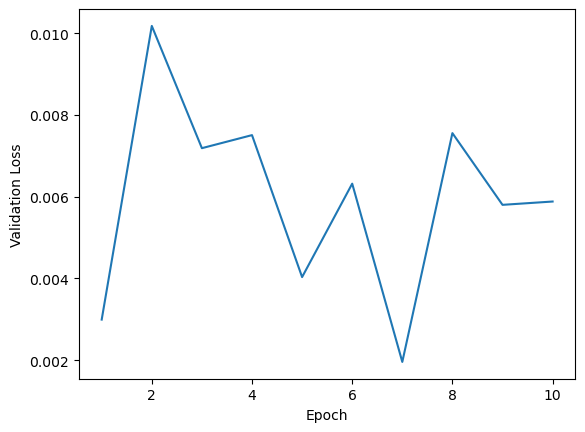

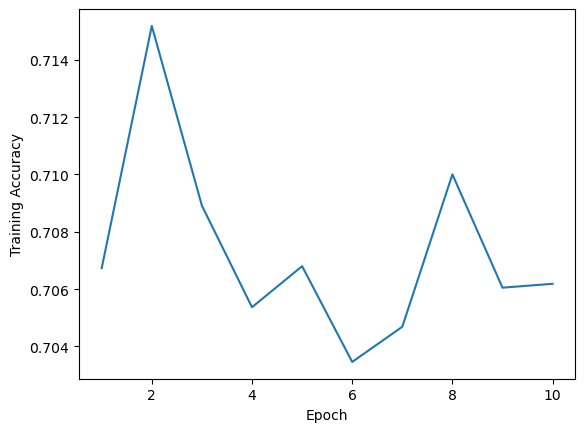

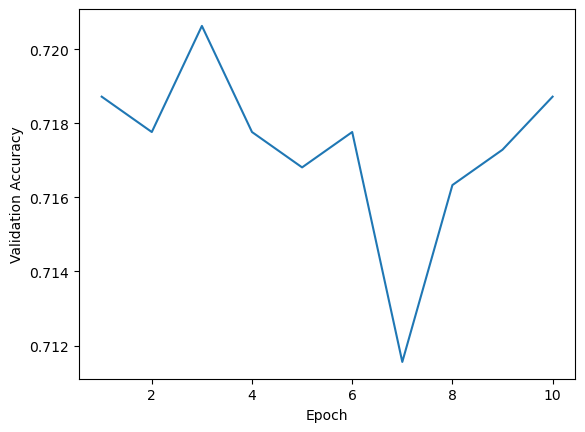

In [22]:
import pandas as pd

# df = pd.read_csv("../input/animal10csv/Mobilenet.csv")

plt.figure("Epoch vs Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.plot(result_df["epoch"], result_df["train_loss"])
plt.show()

plt.figure("Epoch vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.plot(result_df["epoch"], result_df["val_loss"])
plt.show()

plt.figure("Epoch vs Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Training Accuracy")
plt.plot(result_df["epoch"], result_df["train_acc"])
plt.show()

plt.figure("Epoch vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.plot(result_df["epoch"], result_df["val_acc"])
plt.show()

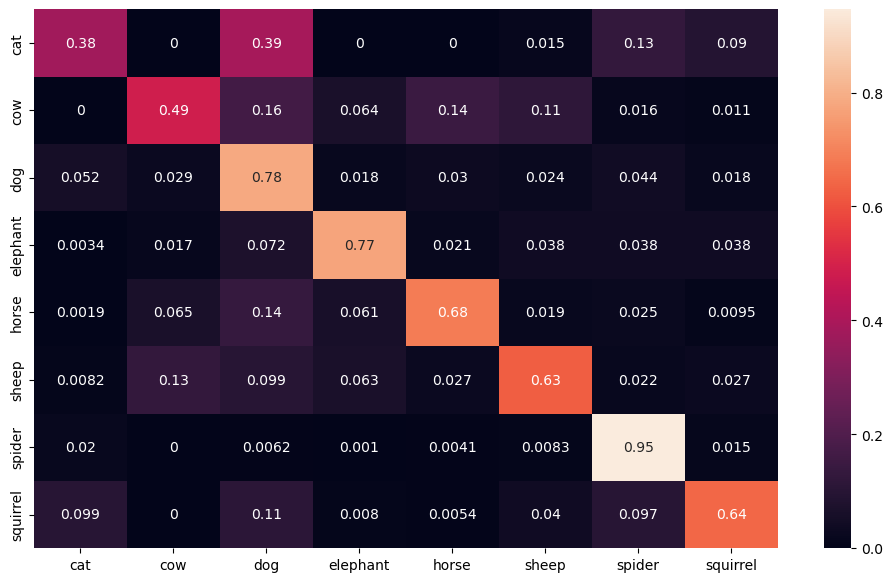

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = testset.classes

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

In [25]:
from sklearn.metrics import accuracy_score, classification_report

# print accuracy
print("Overall Accuracy: ", round(accuracy_score(y_true, y_pred)*100,2)," %")

# print precision, recall, F1-score per each class/tag
print(classification_report(y_true, y_pred,target_names=testset.classes))

Overall Accuracy:  72.3  %

              precision    recall  f1-score   support



         cat       0.53      0.38      0.44       335

         cow       0.62      0.49      0.54       374

         dog       0.68      0.78      0.73       973

    elephant       0.69      0.77      0.73       290

       horse       0.77      0.68      0.73       525

       sheep       0.66      0.63      0.64       364

      spider       0.85      0.95      0.90       965

    squirrel       0.72      0.64      0.68       373



    accuracy                           0.72      4199

   macro avg       0.69      0.67      0.67      4199

weighted avg       0.72      0.72      0.72      4199


